<a href="https://colab.research.google.com/github/kirill-kozlitin/VTB/blob/main/check_autologreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

Провести тестирование выборки на предмет применимости в тестах
1. Построить автологрег
2. Оценить фичи, которые входят

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install xlsxwriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 2.9 MB/s eta 0:00:00


In [4]:
!pip install optbinning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 23.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3


In [5]:
import pandas as pd
import sys

path = 'drive/MyDrive/VTB/'
sys.path.append(path)

import vtb_mlkit
from vtb_mlkit.scorekit.model import LogisticRegressionModel
from vtb_mlkit.scorekit.data import DataSamples


(CVXPY) Jul 21 11:30:51 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jul 21 11:30:51 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


In [6]:
data = pd.read_csv(path + 'accepted_2007_to_2018Q4.csv.gz', compression='gzip', nrows=1*10**4)

In [39]:
data['issue_d'].unique()

array(['Dec-2015'], dtype=object)

In [7]:
# data[['term', 'pymnt_plan', 'initial_list_status', 'application_type', 'hardship_flag', 'debt_settlement_flag']]
data['loan_status'].value_counts(dropna=False)

Fully Paid            7189
Charged Off           1713
Current               1024
Late (31-120 days)      58
In Grace Period         12
Late (16-30 days)        4
Name: loan_status, dtype: int64

In [8]:
data['target'] = data['loan_status'].apply(lambda x: 0 if x == 'Fully Paid' else 1)

In [9]:
bad_features = ['id', # понятно
                'member_id', # понятно
                'desc', # описание кредита
                'title', # описание кредита
                'last_pymnt_amnt', # сумма посл. платежа. (лик)
                'acc_now_delinq', # кол. просрочек сейчас (лик)
                'total_pymnt', # уплач. сумма (лик)
                'total_pymnt_inv', # уплач. проц (лик)
                'total_rec_prncp', # уплач. сумма (лик)
                'total_rec_int', # уплач. проц (лик)
                'total_rec_late_fee', # уплач. проц (лик)
                'next_pymnt_d', # дата след. платежа (лик)
                'last_pymnt_amnt', # сумма послед. платежа (лик)
                'last_fico_range_low', # рейтинг текущ. (лик)
                'last_fico_range_high', # рейтинг текущ. (лик)
                'loan_status', # текущ. статус (лик)
                ]

In [10]:
data.drop(bad_features, axis='columns', inplace=True)

In [11]:
ds = DataSamples(samples={'train': data.copy()}, target='target', result_folder='titanic_output', samples_split={}, bootstrap_split={}, ci_analytic=False)

logreg = LogisticRegressionModel(clf=None,            # классификатор модели (должен иметь метод fit() и атрибуты coef_, intercept_). При None выбирается SGDClassifier(alpha=0.001, loss='log', max_iter=100)
                                 ds=ds,               # Привязанный к модели ДатаСэмпл. Если задан, то он по умолчанию будет использоваться во всех методах
                                 transformer=None,    # объект класса WOE для предварительной трансформации факторов
                                 round_digits=3,      # округление коэффициентов до этого кол-ва знаков после запятой
                                 name='loan',      # название модели
                                )


[INFO] [2023-07-21 11:30:53] ---------------------------------------------------------------- Creating DataSamples ----------------------------------------------------------------
[INFO] [2023-07-21 11:30:53] Selected 126 features: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'pymnt_plan', 'purpose', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il'

[INFO] [2023-07-21 11:30:56] ------------------------------------------------------------------------ SFA -------------------------------------------------------------------------
[INFO] [2023-07-21 11:30:56] Performing autobinning with parameters space of size 1...
[INFO] [2023-07-21 11:30:56] Using parameters set 1/1: {'method': 'opt', 'max_n_bins': 10, 'min_bin_size': 0.05, 'criterion': 'entropy', 'scoring': 'neg_log_loss', 'max_depth': 5, 'solver': 'cp', 'divergence': 'iv', 'WOEM_on': True, 'WOEM_woe_threshold': 0.05, 'WOEM_with_missing': False, 'SM_on': False, 'SM_target_threshold': 5, 'SM_size_threshold': 100, 'G_on': False, 'G_gini_threshold': 5, 'G_gini_decrease_threshold': 0.25, 'G_gini_increase_restrict': False, 'G_with_test': False, 'BL_on': True, 'BL_allow_Vlogic_to_increase_gini': 10, 'WOEO_on': True, 'WOEO_all_samples': False, 'verbose': False}
[INFO] [2023-07-21 11:30:56] Processing 126 features on 1 CPU...


100%|██████████| 126/126 [03:30<00:00,  1.67s/it]


[INFO] [2023-07-21 11:34:28] Excluded 48 features ['emp_length', 'issue_d', 'pymnt_plan', 'mths_since_last_record', 'pub_rec', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'tot_coll_amt', 'total_cu_tl', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_rcnt_rev_tl_op', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_rev_accts', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'tax_liens', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'hardship_flag', 'hardship_reason', 'hardship_status', 'hardship_amount', 'hardship_dpd',

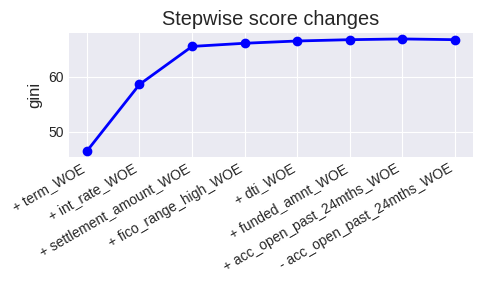

[INFO] [2023-07-21 11:35:12] ---------------------------------------------- Step 4 ----------------------------------------------
[INFO] [2023-07-21 11:35:12] Dropping features with positive coefs and high p-values...
[INFO] [2023-07-21 11:35:12] Nothing to drop
[INFO] [2023-07-21 11:35:12] ------------------------------------------- Final model --------------------------------------------
[INFO] [2023-07-21 11:35:12] intercept = -0.86
[INFO] [2023-07-21 11:35:12] coefs = {'term_WOE': -0.768, 'settlement_amount_WOE': -0.978, 'int_rate_WOE': -0.578, 'funded_amnt_WOE': -0.18, 'fico_range_high_WOE': -0.672, 'dti_WOE': -0.569}
[INFO] [2023-07-21 11:35:12] Generating report...


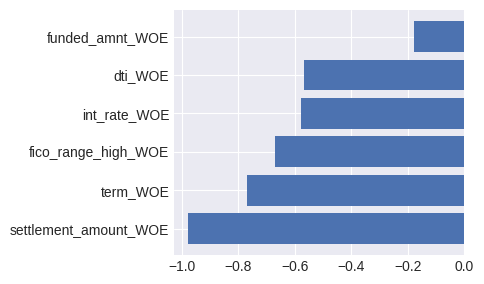

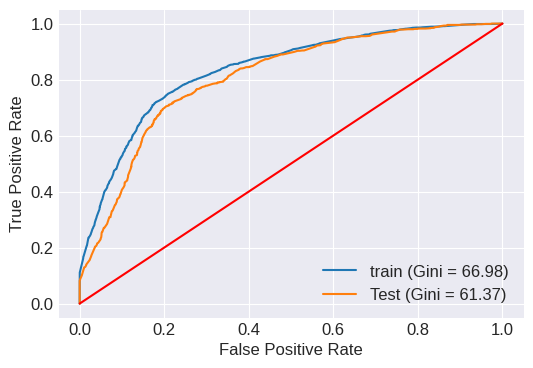

[INFO] [2023-07-21 11:35:17] 
      train   Test  CI_lower  CI_upper
Gini  66.98  61.37     63.48      67.2


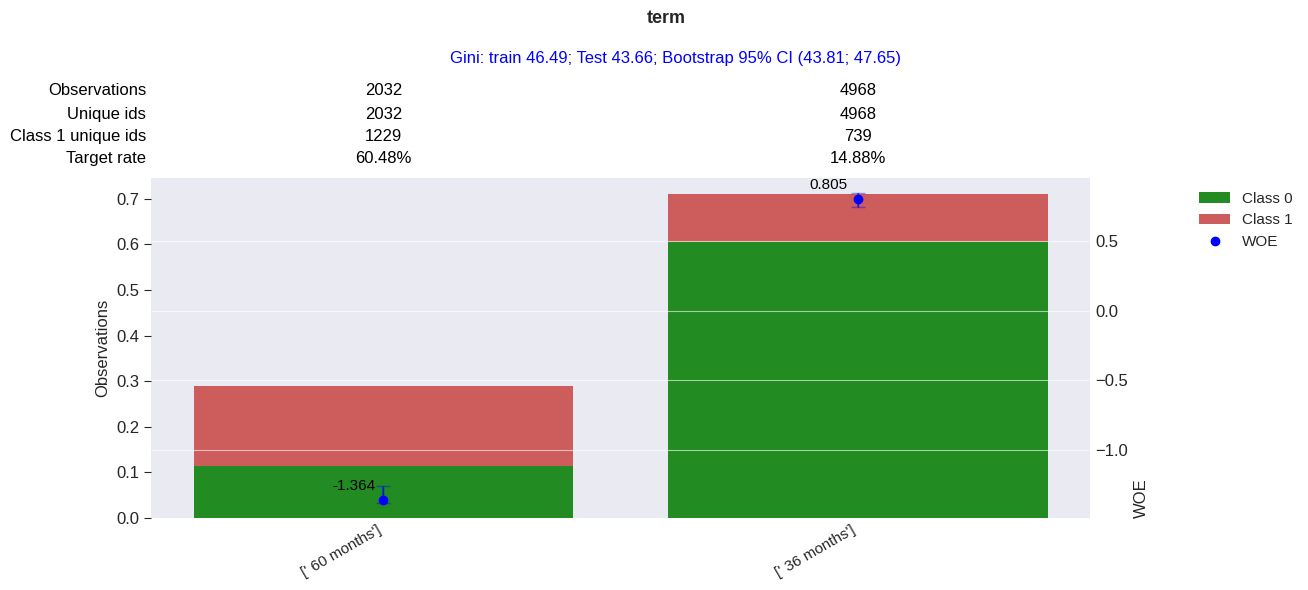

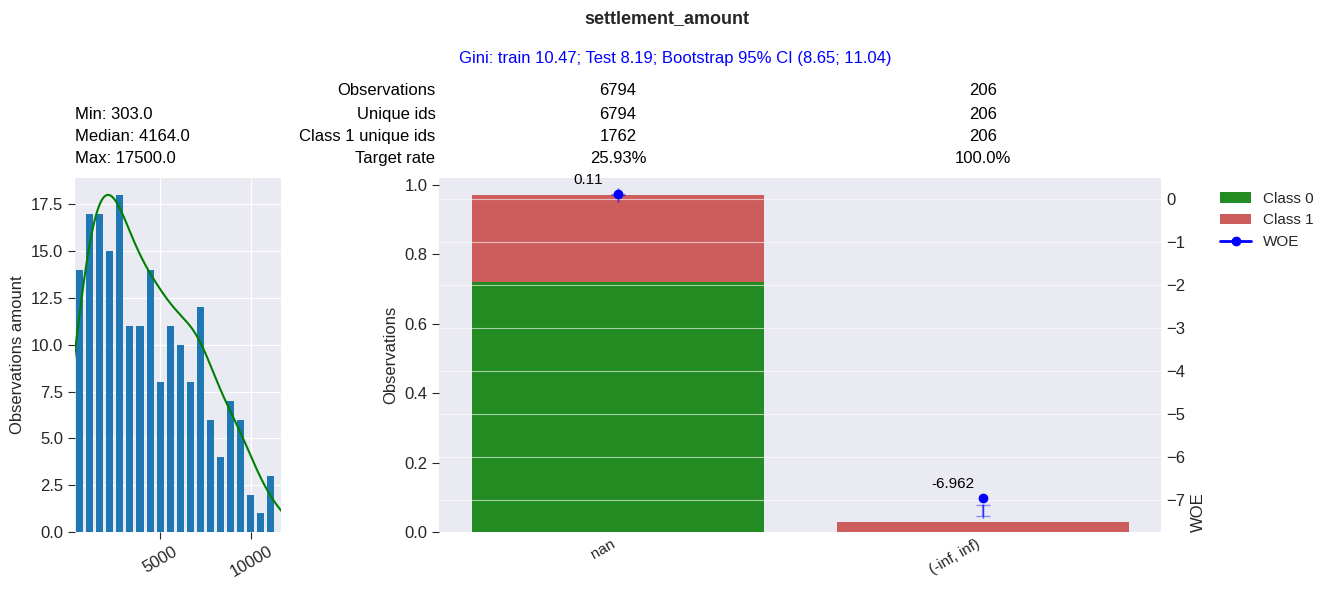

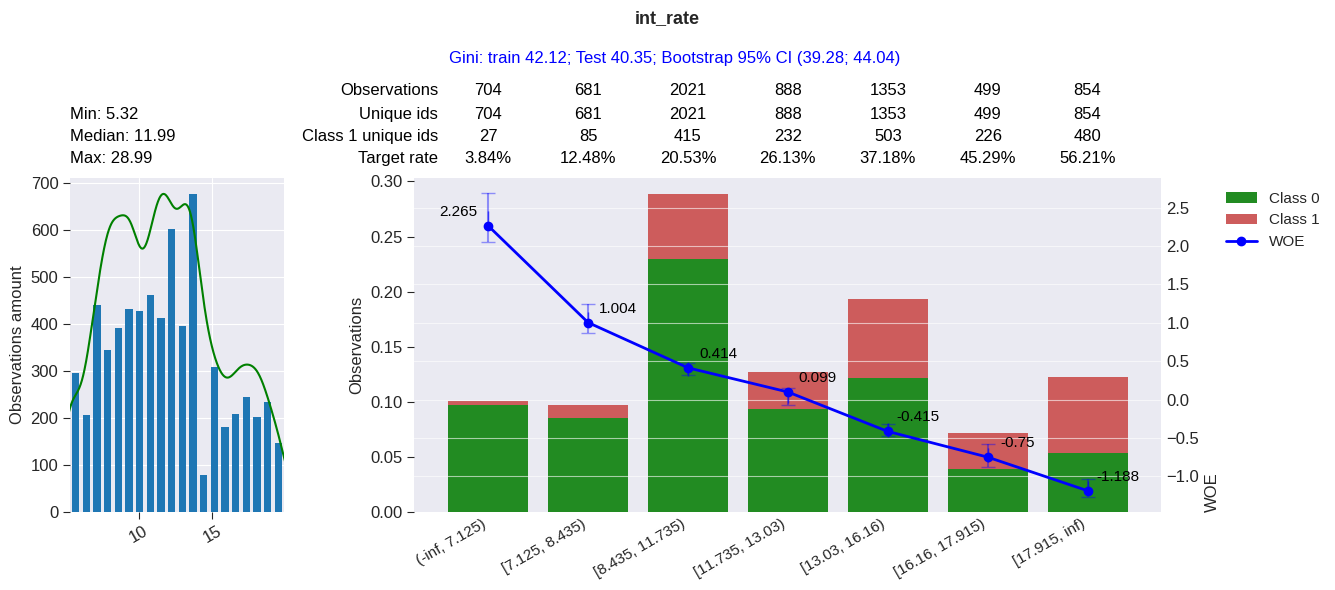

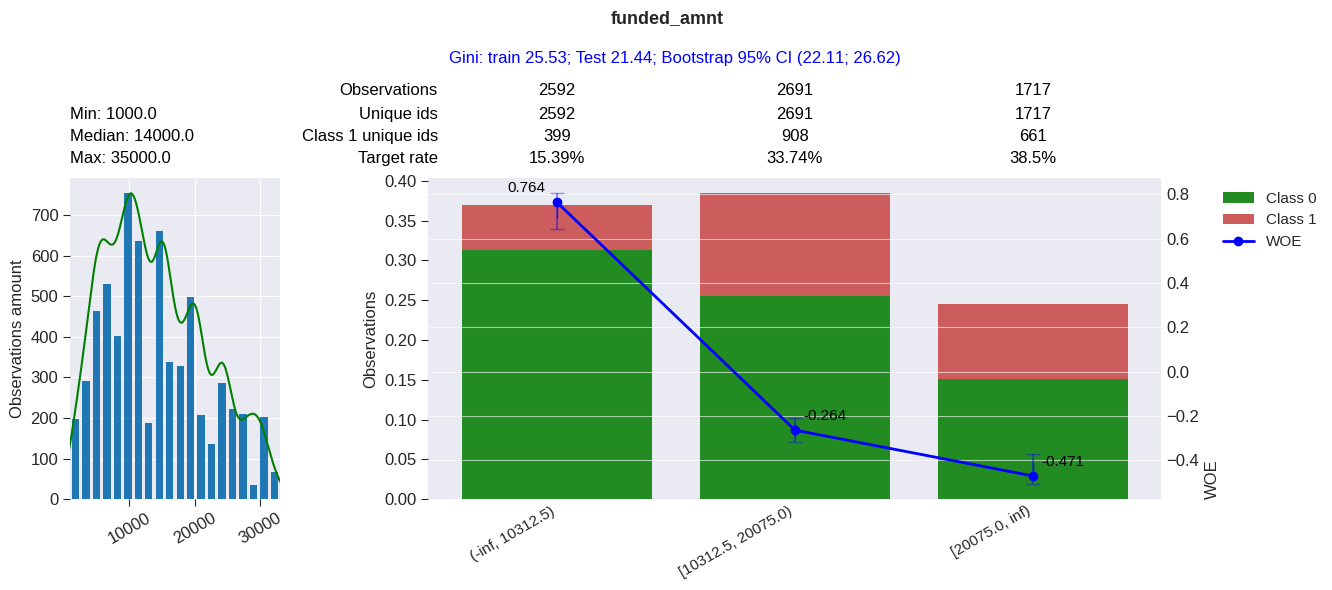

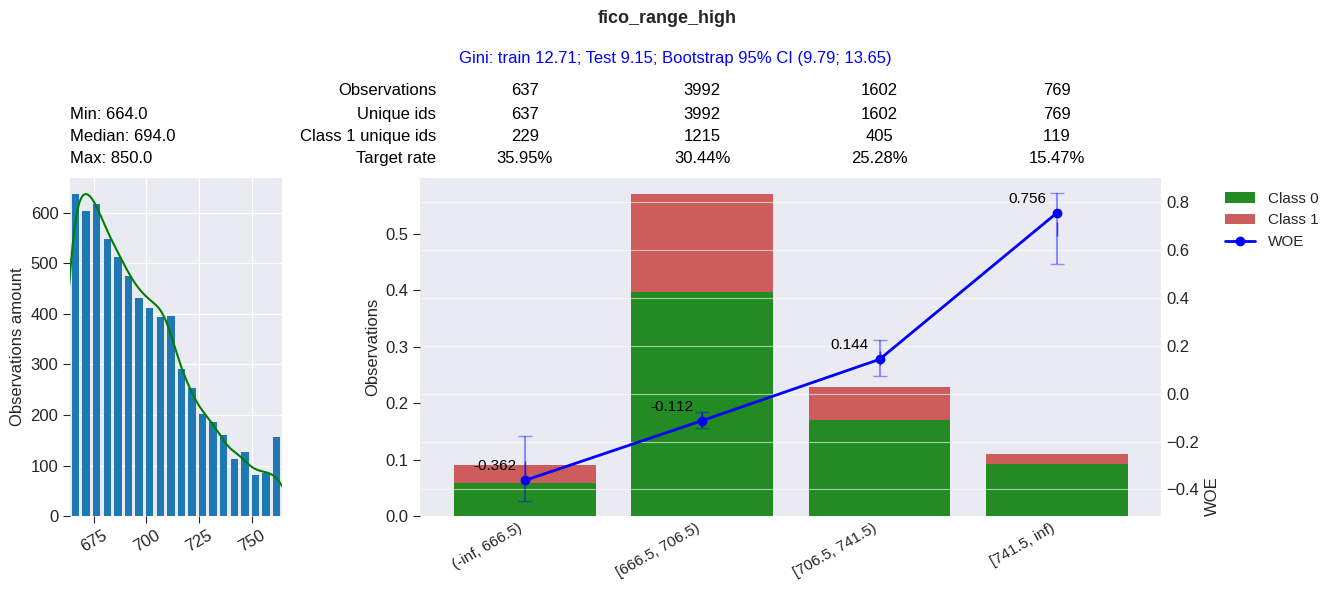

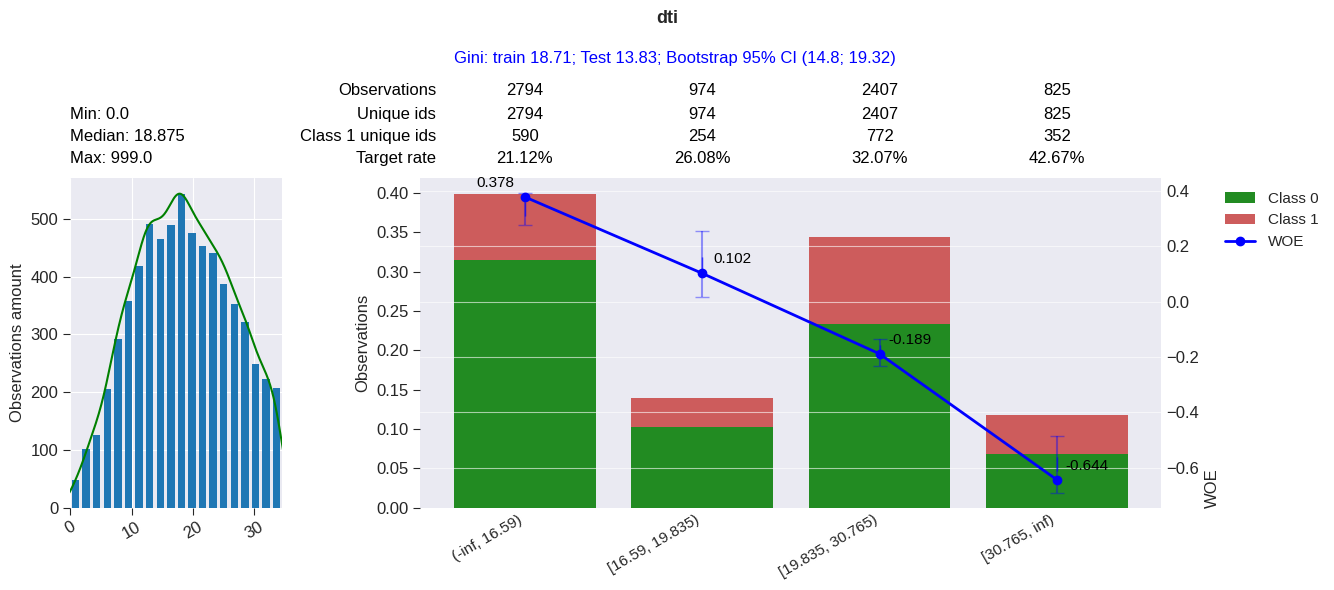

[INFO] [2023-07-21 11:35:38] The model report is saved to file auto_model.xlsx
[INFO] [2023-07-21 11:35:38] The model was successfully saved to file titanic_output/auto_model.json


In [12]:
logreg.auto_logreg(data=None, target=None, time_column=None, id_column=None, feature_descriptions=None, n_jobs=None,
                   result_folder='', method='opt', validate=False, out='auto_model.xlsx', save_model='auto_model.json')

In [13]:
# logreg.features

In [14]:
!pip install tsfresh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.3/95.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 kB 6.0 MB/s eta 0:00:00


In [15]:
ds = DataSamples(samples={'train': data.copy()}, target='target', result_folder='titanic_output')

[INFO] [2023-07-21 11:35:44] ---------------------------------------------------------------- Creating DataSamples ----------------------------------------------------------------
[INFO] [2023-07-21 11:35:44] Selected 126 features: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'pymnt_plan', 'purpose', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il'

In [16]:
ds.features

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'pymnt_plan',
 'purpose',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'recoveries',
 'collection_recovery_fee',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_op

In [17]:
ds.feature_generator(features=None, prebinning=True, chunk_size=10000, gini_threshold=10, operands=True,
                     lags=True, aggs=None, corr_method='spearman', corr_thres=0.80)

[INFO] [2023-07-21 11:35:51] Creating combinations...


100%|██████████| 408/408 [00:43<00:00,  9.45it/s] 

[INFO] [2023-07-21 11:36:34] 408 features were generated, 79 of them passed the tests and were added to sample train


In [18]:
ds.features

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'pymnt_plan',
 'purpose',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'recoveries',
 'collection_recovery_fee',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_op

In [19]:
ds.samples_split(df=None, test_size=.3, validate_size=0, split_type='oos', stratify=True, id_column=None)

[INFO] [2023-07-21 11:36:34] Actual parts of samples after samples split:
      train  Test
part    0.7   0.3


In [20]:
logreg = LogisticRegressionModel(clf=None,            # классификатор модели (должен иметь метод fit() и атрибуты coef_, intercept_). При None выбирается SGDClassifier(alpha=0.001, loss='log', max_iter=100)
                                 ds=ds,               # Привязанный к модели ДатаСэмпл. Если задан, то он по умолчанию будет использоваться во всех методах
                                 transformer=None,    # объект класса WOE для предварительной трансформации факторов
                                 round_digits=3,      # округление коэффициентов до этого кол-ва знаков после запятой
                                 name='loan',      # название модели
                                )


[INFO] [2023-07-21 11:36:34] Chosen model classifier is SGDClassifier(alpha=0.001, loss='log', random_state=0)


[INFO] [2023-07-21 11:36:34] ------------------------------------------------------------------------ SFA -------------------------------------------------------------------------
[INFO] [2023-07-21 11:36:34] Performing autobinning with parameters space of size 1...
[INFO] [2023-07-21 11:36:34] Using parameters set 1/1: {'method': 'opt', 'max_n_bins': 10, 'min_bin_size': 0.05, 'criterion': 'entropy', 'scoring': 'neg_log_loss', 'max_depth': 5, 'solver': 'cp', 'divergence': 'iv', 'WOEM_on': True, 'WOEM_woe_threshold': 0.05, 'WOEM_with_missing': False, 'SM_on': False, 'SM_target_threshold': 5, 'SM_size_threshold': 100, 'G_on': False, 'G_gini_threshold': 5, 'G_gini_decrease_threshold': 0.25, 'G_gini_increase_restrict': False, 'G_with_test': False, 'BL_on': True, 'BL_allow_Vlogic_to_increase_gini': 10, 'WOEO_on': True, 'WOEO_all_samples': False, 'verbose': False}
[INFO] [2023-07-21 11:36:34] Processing 205 features on 1 CPU...


100%|██████████| 205/205 [01:41<00:00,  2.03it/s]


[INFO] [2023-07-21 11:38:19] Excluded 51 features ['emp_length', 'annual_inc', 'issue_d', 'pymnt_plan', 'mths_since_last_record', 'pub_rec', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'tot_coll_amt', 'max_bal_bc', 'total_cu_tl', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'num_bc_tl', 'num_rev_accts', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'tax_liens', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'hardship_flag', 'hardship_reason', 'hardship_status', 'hardship_amount', 'hardship_dpd', 'hardshi

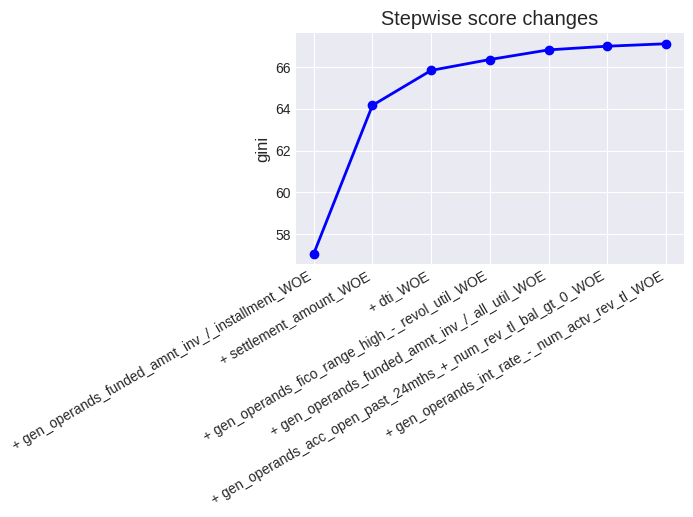

[INFO] [2023-07-21 11:39:19] ---------------------------------------------- Step 4 ----------------------------------------------
[INFO] [2023-07-21 11:39:20] Dropping features with positive coefs and high p-values...
[INFO] [2023-07-21 11:39:20] Nothing to drop
[INFO] [2023-07-21 11:39:20] ------------------------------------------- Final model --------------------------------------------
[INFO] [2023-07-21 11:39:20] intercept = -0.959
[INFO] [2023-07-21 11:39:20] coefs = {'settlement_amount_WOE': -1.0, 'gen_operands_int_rate_-_num_actv_rev_tl_WOE': -0.178, 'gen_operands_funded_amnt_inv_/_installment_WOE': -0.835, 'gen_operands_funded_amnt_inv_/_all_util_WOE': -0.477, 'gen_operands_fico_range_high_-_revol_util_WOE': -0.614, 'gen_operands_acc_open_past_24mths_+_num_rev_tl_bal_gt_0_WOE': -0.446, 'dti_WOE': -0.487}
[INFO] [2023-07-21 11:39:21] Generating report...


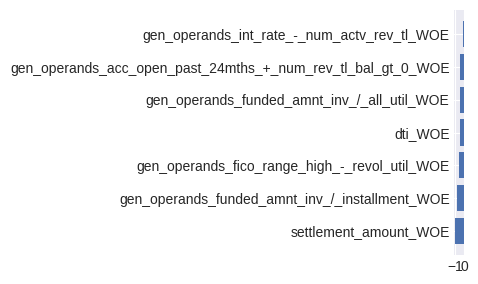

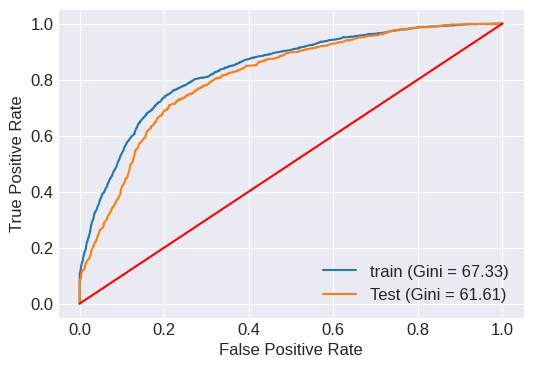

[INFO] [2023-07-21 11:39:24] 
      train   Test  CI_lower  CI_upper
Gini  67.33  61.61     64.99     69.66


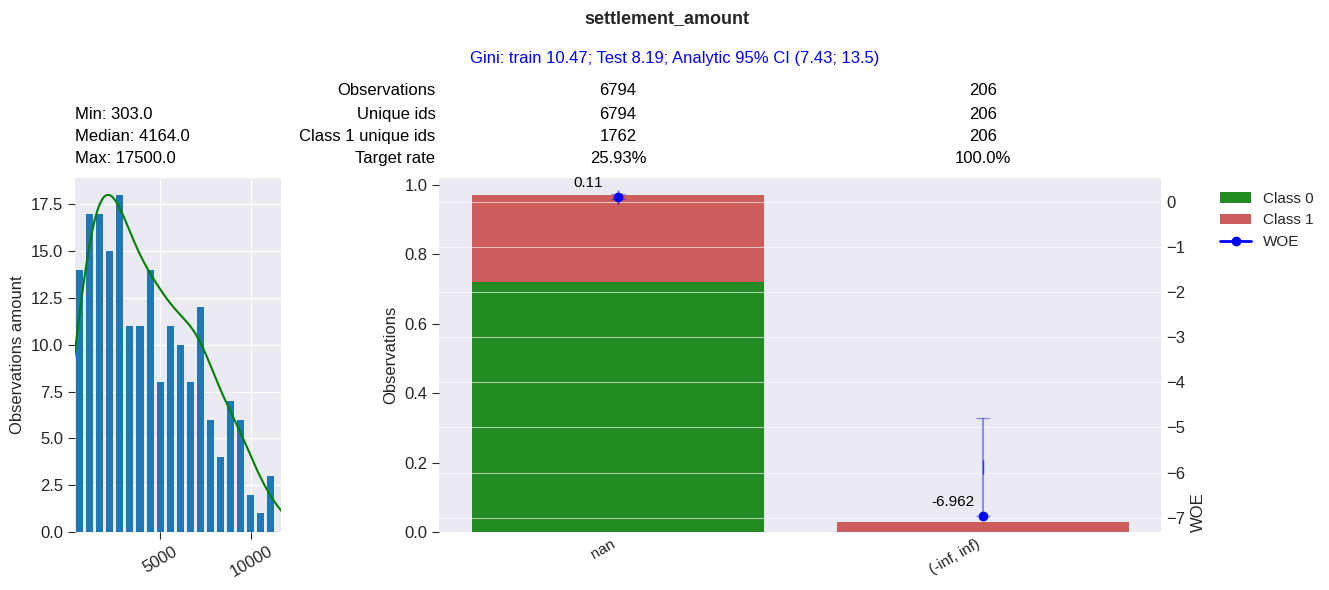

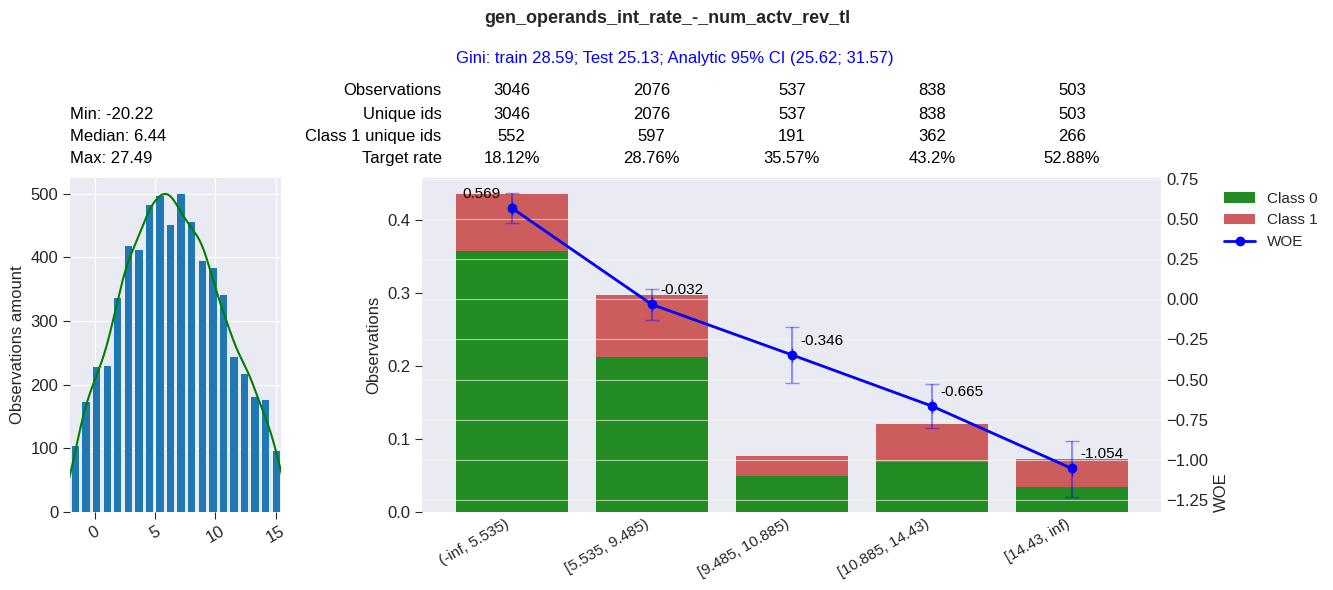

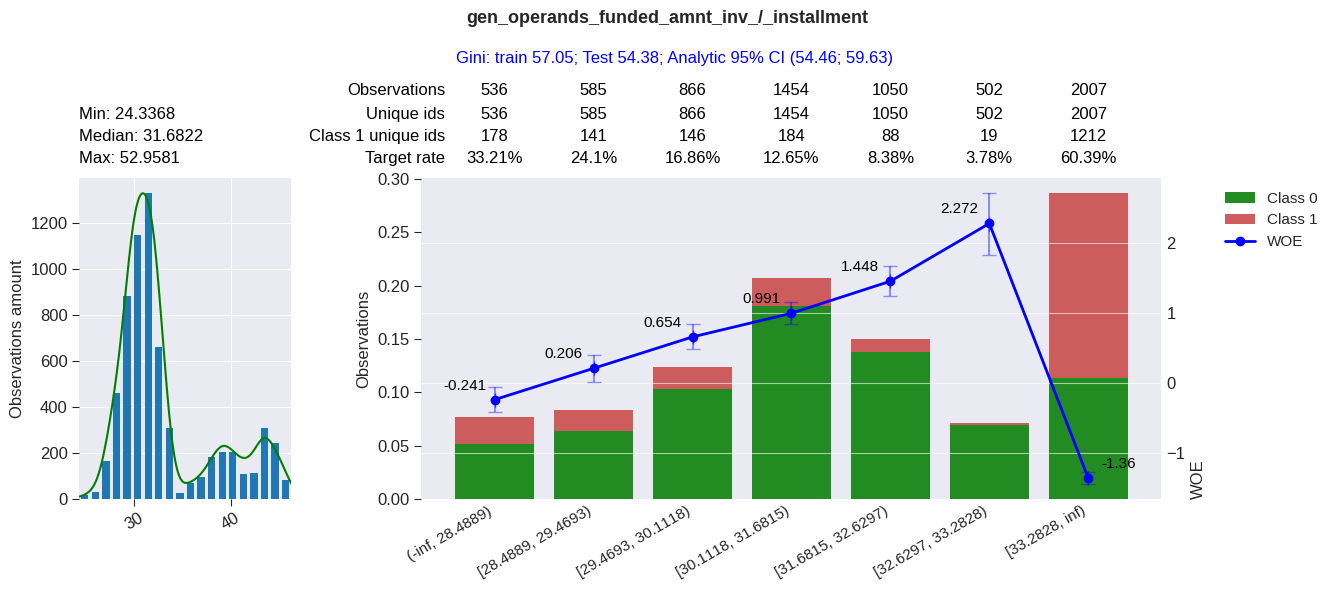

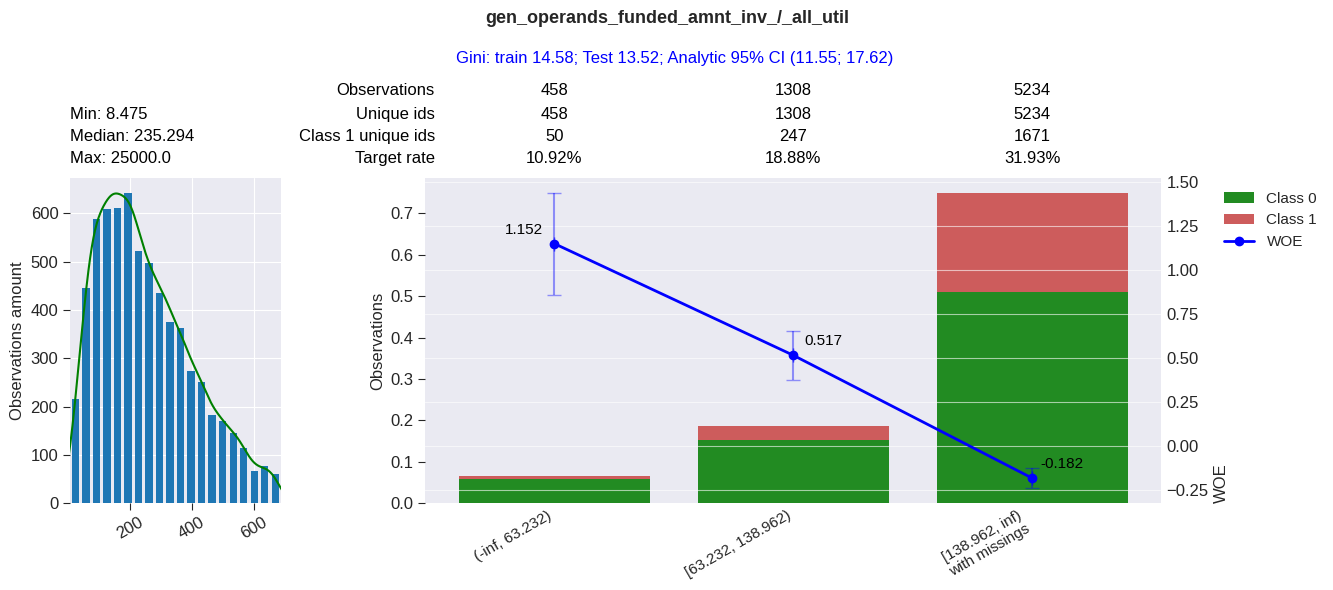

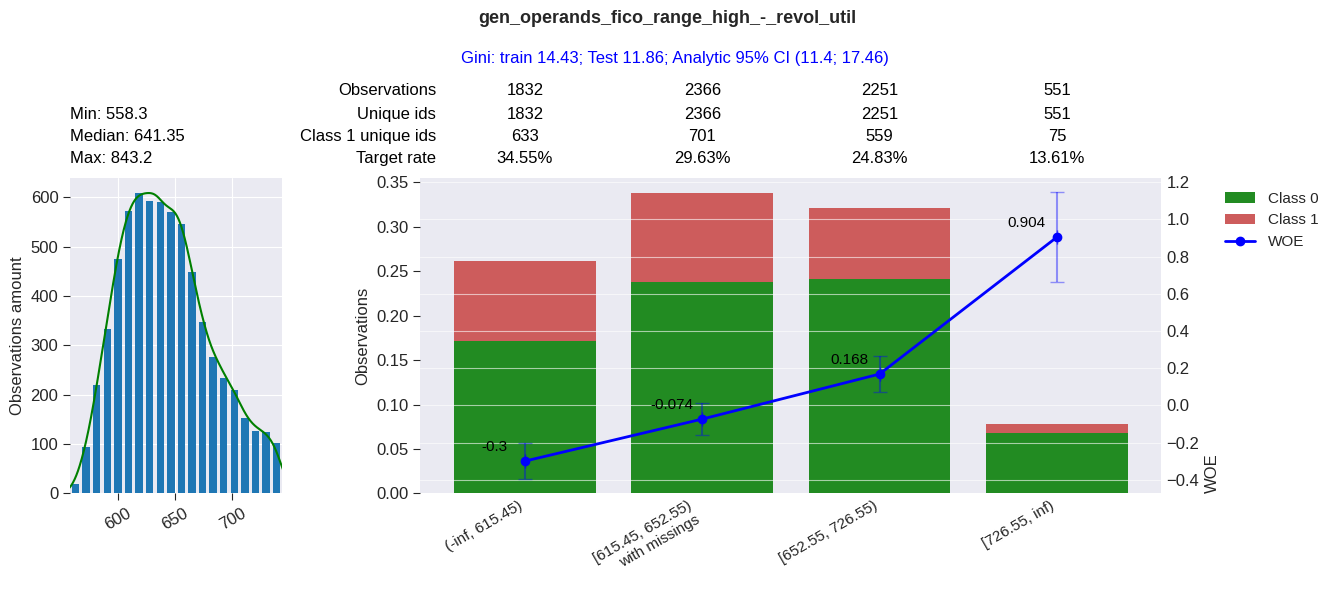

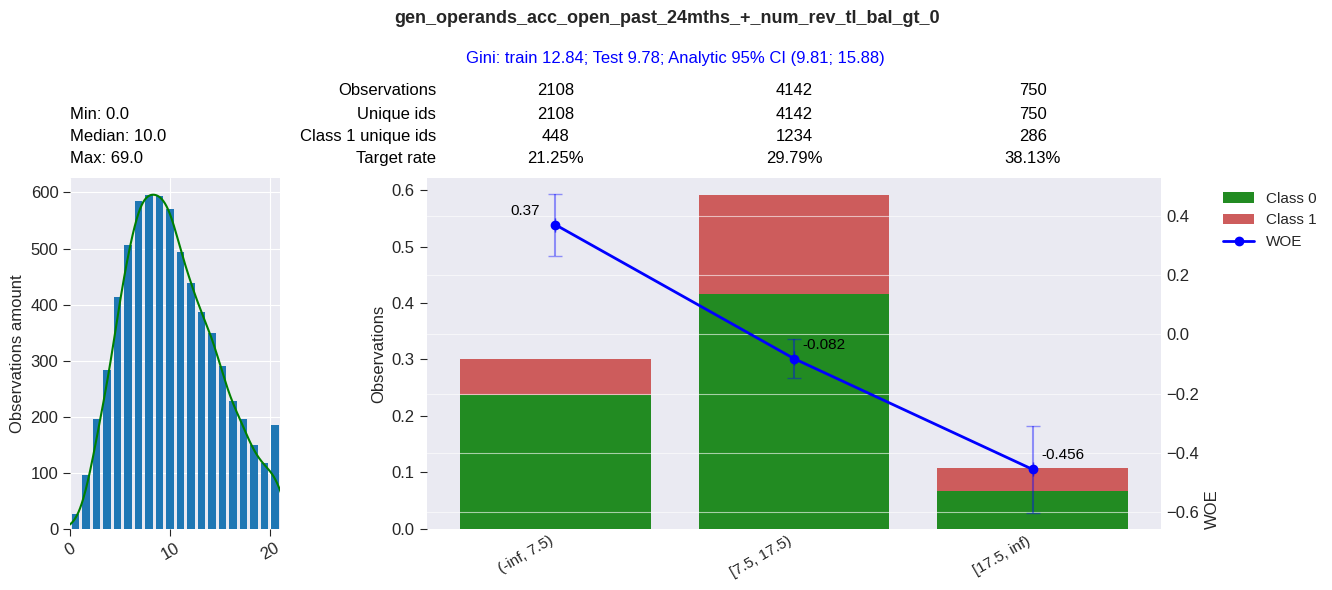

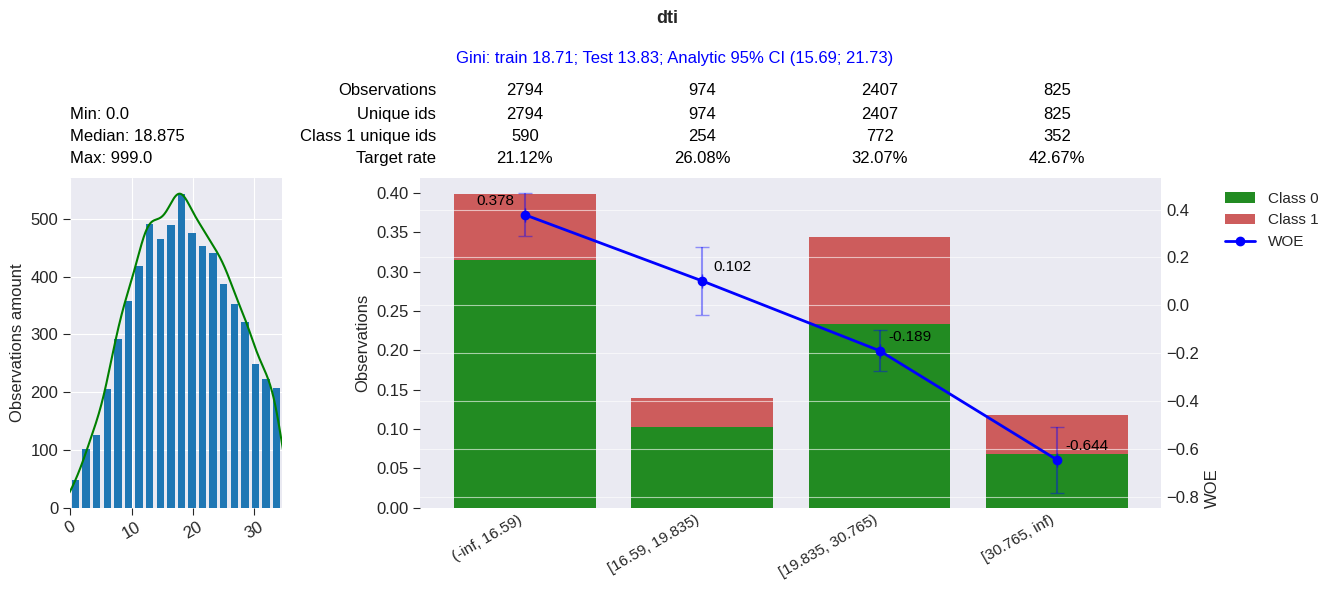

[INFO] [2023-07-21 11:39:39] The model report is saved to file auto_model.xlsx
[INFO] [2023-07-21 11:39:39] The model was successfully saved to file titanic_output/auto_model.json


In [21]:
logreg.auto_logreg(data=None, target=None, time_column=None, id_column=None, feature_descriptions=None, n_jobs=None,
                   result_folder='', method='opt', validate=False, out='auto_model.xlsx', save_model='auto_model.json')

In [22]:
ds.features

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'pymnt_plan',
 'purpose',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'recoveries',
 'collection_recovery_fee',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_op

In [23]:
logreg.features

['settlement_amount_WOE',
 'gen_operands_int_rate_-_num_actv_rev_tl_WOE',
 'gen_operands_funded_amnt_inv_/_installment_WOE',
 'gen_operands_funded_amnt_inv_/_all_util_WOE',
 'gen_operands_fico_range_high_-_revol_util_WOE',
 'gen_operands_acc_open_past_24mths_+_num_rev_tl_bal_gt_0_WOE',
 'dti_WOE']

In [24]:
# классификатор модели (должен иметь метод fit() и атрибуты coef_, intercept_)
logreg.clf

SGDClassifier(alpha=0.001, loss='log', random_state=0)

In [25]:
# словарь коэффициентов
logreg.coefs

{'settlement_amount_WOE': -1.0,
 'gen_operands_int_rate_-_num_actv_rev_tl_WOE': -0.178,
 'gen_operands_funded_amnt_inv_/_installment_WOE': -0.835,
 'gen_operands_funded_amnt_inv_/_all_util_WOE': -0.477,
 'gen_operands_fico_range_high_-_revol_util_WOE': -0.614,
 'gen_operands_acc_open_past_24mths_+_num_rev_tl_bal_gt_0_WOE': -0.446,
 'dti_WOE': -0.487}

In [26]:
# константа логрега
logreg.intercept

-0.959

In [27]:
# список коэффициентов для калибровки [a, b]
# score_calibr = a + b*score
logreg.calibration

In [31]:
# словарь шкалы {грейд: верхняя граница PD грейда}
'''
пример мастер-шкалы:
{
'MA1': 0.00050,
'MA2': 0.00069,
'MA3': 0.00097,
'MB1': 0.0013,
'MB2': 0.0019,
'MB3': 0.0027,
'MC1': 0.0038,
'MC2': 0.0053,
'MC3': 0.0075,
'MD1': 0.010,
'MD2': 0.014,
'MD3': 0.020,
'ME1': 0.029,
'ME2': 0.041,
'ME3': 0.057,
'MF1': 0.081,
'MF2': 0.11,
'MF3': 0.16,
'MG1': 0.22,
'MG2': 0.31,
'MG3': 1
}
'''
logreg.scale

In [32]:
logreg.report(ds=None, out='report.xlsx', sheet_name=None, pvalue_threshold=0.05, verbose=False, add_figs=None, gini_df=None,
              plotbins_config=None, metrics=None, metrics_cv=None, cv=None)

[INFO] [2023-07-21 11:46:28] The model report is saved to file report.xlsx


Gini                  \
                                                    train   Test CI_lower   
feature                                                                     
settlement_amount_WOE                               10.47   8.19     7.43   
gen_operands_int_rate_-_num_actv_rev_tl_WOE         28.59  25.13    25.62   
gen_operands_funded_amnt_inv_/_installment_WOE      57.05  54.38    54.46   
gen_operands_funded_amnt_inv_/_all_util_WOE         14.58  13.52    11.55   
gen_operands_fico_range_high_-_revol_util_WOE       14.43  11.86    11.40   
gen_operands_acc_open_past_24mths_+_num_rev_tl_...  12.84   9.78     9.81   
dti_WOE                                             18.71  13.83    15.69   
intercept                                             NaN    NaN      NaN   
model                                               67.33  61.61    64.99   

                                                            coefficient  \
                                                   CI_upper               
feature                                                                   
settlement_amount_WOE                                 13.50      -1.000   
gen_operands_int_rate_-_num_actv_rev_tl_WOE           31.57      -0.178   
gen_operands_funded_amnt_inv_/_installment_WOE        59.63      -0.835   
gen_operands_funded_amnt_inv_/_all_util_WOE           17.62      -0.477   
gen_operands_fico_range_high_-_revol_util_WOE         17.46      -0.614   
gen_operands_acc_open_past_24mths_+_num_rev_tl_...    15.88      -0.446   
dti_WOE                                               21.73      -0.487   
intercept                                               NaN      -0.959   
model                                                 69.66         NaN   

                                                       se Wald p-value  \
                                                                 train   
feature                                                                  
settlement_amount_WOE                               0.155    1.166e-10   
gen_operands_int_rate_-_num_actv_rev_tl_WOE         0.066    7.033e-03   
gen_operands_funded_amnt_inv_/_installment_WOE      0.033   2.225e-141   
gen_operands_funded_amnt_inv_/_all_util_WOE         0.093    3.220e-07   
gen_operands_fico_range_high_-_revol_util_WOE       0.117    1.465e-07   
gen_operands_acc_open_past_24mths_+_num_rev_tl_...  0.130    6.211e-04   
dti_WOE                                             0.091    8.250e-08   
intercept                                           0.036   1.689e-155   
model                                                 NaN          NaN   

                                                                  ks         \
                                                         Test  train   Test   
feature                                                                       
settlement_amount_WOE                               4.353e-04  0.105  0.082   
gen_operands_int_rate_-_num_actv_rev_tl_WOE         7.979e-02  0.215  0.184   
gen_operands_funded_amnt_inv_/_installment_WOE      1.655e-61  0.477  0.467   
gen_operands_funded_amnt_inv_/_all_util_WOE         6.249e-04  0.141  0.131   
gen_operands_fico_range_high_-_revol_util_WOE       5.085e-04  0.109  0.083   
gen_operands_acc_open_past_24mths_+_num_rev_tl_...  2.419e-02  0.102  0.065   
dti_WOE                                             3.456e-04  0.152  0.123   
intercept                                           8.984e-62    NaN    NaN   
model                                                     NaN  0.540  0.497   

                                                      vif            iv         
                                                    train   Test  train   Test  
feature                                                                         
settlement_amount_WOE                               1.007  1.005  0.000  0.000  
gen_operands_int_rate_-_num_actv_rev_tl_WOE         1.564  1.621 